<a href="https://colab.research.google.com/github/StrikerEureka34/3D-Object-Classification/blob/main/Project_Update.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install h5py numpy matplotlib tensorflow


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
/content/drive/MyDrive/data_sets/modelnet40_hdf5_2048/modelnet40_hdf5_2048


Mounted at /content/drive


In [ ]:
#Debug code for path
DATASET_PATH = '/content/drive/MyDrive/data_sets/modelnet40_hdf5_2048/modelnet40_hdf5_2048'

# Check if the dataset folder exists
import os
if os.path.exists(DATASET_PATH):
    print("Dataset folder exists.")
    print("Files in dataset folder:")
    print(os.listdir(DATASET_PATH))
else:
    print("Dataset folder does not exist. Check your path.")


Dataset folder exists.
Files in dataset folder:
['test0_id2name.json', 'test1_id2file.json', 'test1_id2name.json', 'train3_id2name.json', 'train1.h5', 'train0.h5', 'train4_id2file.json', 'train4_id2name.json', 'test_files.txt', 'train4.h5', 'train2_id2file.json', 'train0_id2file.json', 'train2.h5', 'train3_id2file.json', 'test1.h5', 'train1_id2file.json', 'test0_id2file.json', 'train0_id2name.json', 'train2_id2name.json', 'shape_names.txt', 'train1_id2name.json', 'train_files.txt', 'test0.h5', 'train3.h5']


In [ ]:
import h5py
import numpy as np
import glob

def load_h5_data(data_dir):
    """
    Loads ModelNet40 data from H5 files

    Args:
        data_dir: Directory containing the H5 files

    Returns:
        train_points, test_points, train_labels, test_labels, class_map
    """
    #Class names
    with open(os.path.join(data_dir, "shape_names.txt"), 'r') as f:
        class_names = [line.strip() for line in f]

    class_map = {i: name for i, name in enumerate(class_names)}

    #Training data
    train_files = sorted(glob.glob(os.path.join(data_dir, "train*.h5")))
    train_points = []
    train_labels = []

    for train_file in train_files:
        print(f"Loading {train_file}...")
        with h5py.File(train_file, 'r') as f:
            train_points.append(f['data'][:])
            train_labels.append(f['label'][:].flatten())

    #Testing data
    test_files = sorted(glob.glob(os.path.join(data_dir, "test*.h5")))
    test_points = []
    test_labels = []

    for test_file in test_files:
        print(f"Loading {test_file}...")
        with h5py.File(test_file, 'r') as f:
            test_points.append(f['data'][:])
            test_labels.append(f['label'][:].flatten())

    #Concatenate data
    train_points = np.concatenate(train_points, axis=0)
    train_labels = np.concatenate(train_labels, axis=0)
    test_points = np.concatenate(test_points, axis=0)
    test_labels = np.concatenate(test_labels, axis=0)

    print(f"Loaded {train_points.shape[0]} training samples")
    print(f"Loaded {test_points.shape[0]} testing samples")
    print(f"Found {len(class_map)} classes")

    return train_points, test_points, train_labels, test_labels, class_map

#Loading dataset
train_points, test_points, train_labels, test_labels, CLASS_MAP = load_h5_data(DATASET_PATH)


Loading /content/drive/MyDrive/data_sets/modelnet40_hdf5_2048/modelnet40_hdf5_2048/train0.h5...
Loading /content/drive/MyDrive/data_sets/modelnet40_hdf5_2048/modelnet40_hdf5_2048/train1.h5...
Loading /content/drive/MyDrive/data_sets/modelnet40_hdf5_2048/modelnet40_hdf5_2048/train2.h5...
Loading /content/drive/MyDrive/data_sets/modelnet40_hdf5_2048/modelnet40_hdf5_2048/train3.h5...
Loading /content/drive/MyDrive/data_sets/modelnet40_hdf5_2048/modelnet40_hdf5_2048/train4.h5...
Loading /content/drive/MyDrive/data_sets/modelnet40_hdf5_2048/modelnet40_hdf5_2048/test0.h5...
Loading /content/drive/MyDrive/data_sets/modelnet40_hdf5_2048/modelnet40_hdf5_2048/test1.h5...
Loaded 9843 training samples
Loaded 2468 testing samples
Found 40 classes


In [ ]:
def normalize_point_cloud(points):
    #Setting Center at Origin
    centroid = np.mean(points, axis=0)
    points -= centroid
    #Scaling to unit Sphere
    max_distance = np.max(np.sqrt(np.sum(points**2, axis=1)))
    points /= max_distance
    return points

#Normalization to all cloud points
train_points = np.array([normalize_point_cloud(p) for p in train_points])
test_points = np.array([normalize_point_cloud(p) for p in test_points])


In [ ]:
import tensorflow as tf

def create_datasets(train_points, test_points, train_labels, test_labels, batch_size=32):
    """
    Creates TensorFlow datasets for training and evaluation.

    Args:
        train_points: Training point clouds
        test_points: Testing point clouds
        train_labels: Training labels
        test_labels: Testing labels
        batch_size: Batch size for training

    Returns:
        train_dataset, validation_dataset
    """
    def augment(points, label):
        # Jitter points (small random noise)
        points += tf.random.normal(points.shape, mean=0.0, stddev=0.01)

        # Random rotation about z-axis
        theta = tf.random.uniform((), 0, 2 * np.pi)
        cos_theta = tf.cos(theta)
        sin_theta = tf.sin(theta)

        rotation_matrix = tf.stack([
            [cos_theta, -sin_theta, 0],
            [sin_theta, cos_theta, 0],
            [0, 0, 1]
        ])

        points = tf.matmul(points, rotation_matrix)

        # Random scaling (between 80% and 120%)
        scale = tf.random.uniform((), 0.8, 1.2)
        points *= scale

        return points, label

    #Dataset Creation
    train_dataset = tf.data.Dataset.from_tensor_slices((train_points.astype(np.float32), train_labels))
    test_dataset = tf.data.Dataset.from_tensor_slices((test_points.astype(np.float32), test_labels))

    # Shuffle and apply augmentation to training data only
    train_dataset = train_dataset.shuffle(len(train_points)).map(augment).batch(batch_size).prefetch(tf.data.AUTOTUNE)

    validation_dataset = test_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return train_dataset, validation_dataset

#Dataset Creation
BATCH_SIZE = 32
train_dataset, validation_dataset = create_datasets(train_points, test_points, train_labels, test_labels, BATCH_SIZE)


In [ ]:
from keras import layers
import tensorflow as tf

def create_pointnet_model(num_classes):
    inputs = layers.Input(shape=(2048, 3))

    # Input transformation network
    x = layers.Conv1D(64, kernel_size=1)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    # Feature transformation network
    x = layers.Conv1D(128, kernel_size=1)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    # Global feature extraction
    x = layers.Conv1D(256, kernel_size=1)(x)
    x = layers.BatchNormalization()(x)
    x = layers.GlobalMaxPooling1D()(x)

    # Fully connected layers
    x = layers.Dense(256)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Dense(128)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.3)(x)

    # Output layer
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

    # Create model
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name="pointnet")

    return model

# Create the model instance
NUM_CLASSES = len(CLASS_MAP)  # Use the number of classes from your dataset
model = create_pointnet_model(NUM_CLASSES)
model.summary()


Model: "pointnet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 2048, 3)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 2048, 64)            │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 2048, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 2048, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 2048, 128)           │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 2048, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 2048, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 2048, 256)           │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 2048, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ (None, 256)                 │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 148,776 (581.16 KB)

 Trainable params: 147,112 (574.66 KB)

 Non-trainable params: 1,664 (6.50 KB)

In [ ]:
# Compile the model
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=["sparse_categorical_accuracy"]
)

# Train the model
print("Training model...")
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5, min_lr=1e-5),
        tf.keras.callbacks.ModelCheckpoint(
            filepath='/content/drive/MyDrive/data_sets/Saved_Model/best_model.h5',
            save_best_only=True,
            monitor='val_sparse_categorical_accuracy'
        )
    ]
)

import os

# Ensure directory exists
save_dir = "/content/drive/MyDrive/data_sets/Saved_Model_improv"
os.makedirs(save_dir, exist_ok=True)

# Save the final trained model in native Keras format
final_model_path = os.path.join(save_dir, "final_model.keras")
model.save(final_model_path)
print(f"Final model saved successfully at {final_model_path}")



Training model...
Epoch 1/50
308/308 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.8935 - sparse_categorical_accuracy: 0.7311

308/308 ━━━━━━━━━━━━━━━━━━━━ 16s 32ms/step - loss: 0.8935 - sparse_categorical_accuracy: 0.7311 - val_loss: 1.3357 - val_sparse_categorical_accuracy: 0.6167 - learning_rate: 0.0010
Epoch 2/50
308/308 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.8833 - sparse_categorical_accuracy: 0.7287

308/308 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.8834 - sparse_categorical_accuracy: 0.7287 - val_loss: 1.1516 - val_sparse_categorical_accuracy: 0.6596 - learning_rate: 0.0010
Epoch 3/50
308/308 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 0.9031 - sparse_categorical_accuracy: 0.7274 - val_loss: 2.0957 - val_sparse_categorical_accuracy: 0.4927 - learning_rate: 0.0010
Epoch 4/50
308/308 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 0.8912 - sparse_categorical_accuracy: 0.7268 - val_loss: 1.5252 - val_sparse_categorical_accuracy: 0.5600 - learning_rate: 0.0010
Epoch 5/50
305/308 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.8773 - sparse_categorical_accuracy: 0.7260

308/308 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - loss: 0.8772 - sparse_categorical_accuracy: 0.7260 - val_loss: 1.1198 - val_sparse_categorical_accuracy: 0.6718 - learning_rate: 0.0010
Epoch 6/50
308/308 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.8843 - sparse_categorical_accuracy: 0.7230 - val_loss: 1.3031 - val_sparse_categorical_accuracy: 0.6317 - learning_rate: 0.0010
Epoch 7/50
308/308 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 0.8923 - sparse_categorical_accuracy: 0.7250 - val_loss: 1.1807 - val_sparse_categorical_accuracy: 0.6240 - learning_rate: 0.0010
Epoch 8/50
308/308 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 0.8629 - sparse_categorical_accuracy: 0.7434 - val_loss: 1.4273 - val_sparse_categorical_accuracy: 0.6053 - learning_rate: 0.0010
Epoch 9/50
308/308 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 0.8473 - sparse_categorical_accuracy: 0.7362 - val_loss: 1.3838 - val_sparse_categorical_accuracy: 0.5960 - learning_rate: 0.0010
Epoch 10/50
308/308 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - 

308/308 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.7975 - sparse_categorical_accuracy: 0.7484 - val_loss: 0.9706 - val_sparse_categorical_accuracy: 0.6989 - learning_rate: 5.0000e-04
Epoch 12/50
308/308 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 0.7678 - sparse_categorical_accuracy: 0.7603 - val_loss: 1.0233 - val_sparse_categorical_accuracy: 0.6892 - learning_rate: 5.0000e-04
Epoch 13/50
308/308 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 0.7682 - sparse_categorical_accuracy: 0.7601 - val_loss: 1.0038 - val_sparse_categorical_accuracy: 0.6937 - learning_rate: 5.0000e-04
Epoch 14/50
307/308 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.7520 - sparse_categorical_accuracy: 0.7644

308/308 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 0.7521 - sparse_categorical_accuracy: 0.7644 - val_loss: 0.8563 - val_sparse_categorical_accuracy: 0.7382 - learning_rate: 5.0000e-04
Epoch 15/50
308/308 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.7575 - sparse_categorical_accuracy: 0.7597 - val_loss: 0.9132 - val_sparse_categorical_accuracy: 0.7306 - learning_rate: 5.0000e-04
Epoch 16/50
308/308 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.7372 - sparse_categorical_accuracy: 0.7669

308/308 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.7373 - sparse_categorical_accuracy: 0.7669 - val_loss: 0.9020 - val_sparse_categorical_accuracy: 0.7403 - learning_rate: 5.0000e-04
Epoch 17/50
308/308 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.7446 - sparse_categorical_accuracy: 0.7642 - val_loss: 0.9098 - val_sparse_categorical_accuracy: 0.7257 - learning_rate: 5.0000e-04
Epoch 18/50
308/308 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.7595 - sparse_categorical_accuracy: 0.7617 - val_loss: 0.8893 - val_sparse_categorical_accuracy: 0.7289 - learning_rate: 5.0000e-04
Epoch 19/50
308/308 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 0.7355 - sparse_categorical_accuracy: 0.7732 - val_loss: 0.8821 - val_sparse_categorical_accuracy: 0.7350 - learning_rate: 5.0000e-04
Epoch 20/50
304/308 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.7321 - sparse_categorical_accuracy: 0.7753

308/308 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 0.7320 - sparse_categorical_accuracy: 0.7753 - val_loss: 0.7552 - val_sparse_categorical_accuracy: 0.7690 - learning_rate: 2.5000e-04
Epoch 21/50
308/308 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 0.7423 - sparse_categorical_accuracy: 0.7695 - val_loss: 0.7332 - val_sparse_categorical_accuracy: 0.7678 - learning_rate: 2.5000e-04
Epoch 22/50
305/308 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.7007 - sparse_categorical_accuracy: 0.7855

308/308 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.7008 - sparse_categorical_accuracy: 0.7854 - val_loss: 0.7157 - val_sparse_categorical_accuracy: 0.7788 - learning_rate: 2.5000e-04
Epoch 23/50
308/308 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 0.6883 - sparse_categorical_accuracy: 0.7830 - val_loss: 0.7495 - val_sparse_categorical_accuracy: 0.7597 - learning_rate: 2.5000e-04
Epoch 24/50
308/308 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 0.7083 - sparse_categorical_accuracy: 0.7877 - val_loss: 0.7668 - val_sparse_categorical_accuracy: 0.7609 - learning_rate: 2.5000e-04
Epoch 25/50
308/308 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 0.7204 - sparse_categorical_accuracy: 0.7694 - val_loss: 0.7667 - val_sparse_categorical_accuracy: 0.7609 - learning_rate: 2.5000e-04
Epoch 26/50
308/308 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - loss: 0.6947 - sparse_categorical_accuracy: 0.7851 - val_loss: 0.7430 - val_sparse_categorical_accuracy: 0.7674 - learning_rate: 2.5000e-04
Epoch 27/50
308/308 ━━━━━━━━━━━━

308/308 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.6805 - sparse_categorical_accuracy: 0.7879 - val_loss: 0.6814 - val_sparse_categorical_accuracy: 0.7889 - learning_rate: 1.2500e-04
Epoch 29/50
308/308 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.6848 - sparse_categorical_accuracy: 0.7874 - val_loss: 0.6987 - val_sparse_categorical_accuracy: 0.7853 - learning_rate: 1.2500e-04
Epoch 30/50
308/308 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.6551 - sparse_categorical_accuracy: 0.7948 - val_loss: 0.6903 - val_sparse_categorical_accuracy: 0.7848 - learning_rate: 1.2500e-04
Epoch 31/50
306/308 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.6572 - sparse_categorical_accuracy: 0.7978

308/308 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - loss: 0.6572 - sparse_categorical_accuracy: 0.7978 - val_loss: 0.6808 - val_sparse_categorical_accuracy: 0.7994 - learning_rate: 1.2500e-04
Epoch 32/50
308/308 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.6521 - sparse_categorical_accuracy: 0.7926 - val_loss: 0.7258 - val_sparse_categorical_accuracy: 0.7735 - learning_rate: 1.2500e-04
Epoch 33/50
308/308 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.6591 - sparse_categorical_accuracy: 0.7971 - val_loss: 0.6976 - val_sparse_categorical_accuracy: 0.7836 - learning_rate: 1.2500e-04
Epoch 34/50
308/308 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 0.6395 - sparse_categorical_accuracy: 0.8000 - val_loss: 0.7186 - val_sparse_categorical_accuracy: 0.7747 - learning_rate: 1.2500e-04
Epoch 35/50
308/308 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 0.6608 - sparse_categorical_accuracy: 0.7865 - val_loss: 0.6709 - val_sparse_categorical_accuracy: 0.7934 - learning_rate: 1.2500e-04
Epoch 36/50
308/308 ━━━━━━━━━━━━

308/308 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.6443 - sparse_categorical_accuracy: 0.7959 - val_loss: 0.6600 - val_sparse_categorical_accuracy: 0.8023 - learning_rate: 6.2500e-05
Epoch 50/50
308/308 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.6407 - sparse_categorical_accuracy: 0.7971 - val_loss: 0.6625 - val_sparse_categorical_accuracy: 0.7962 - learning_rate: 6.2500e-05
Final model saved successfully at /content/drive/MyDrive/data_sets/Saved_Model_improv/final_model.keras


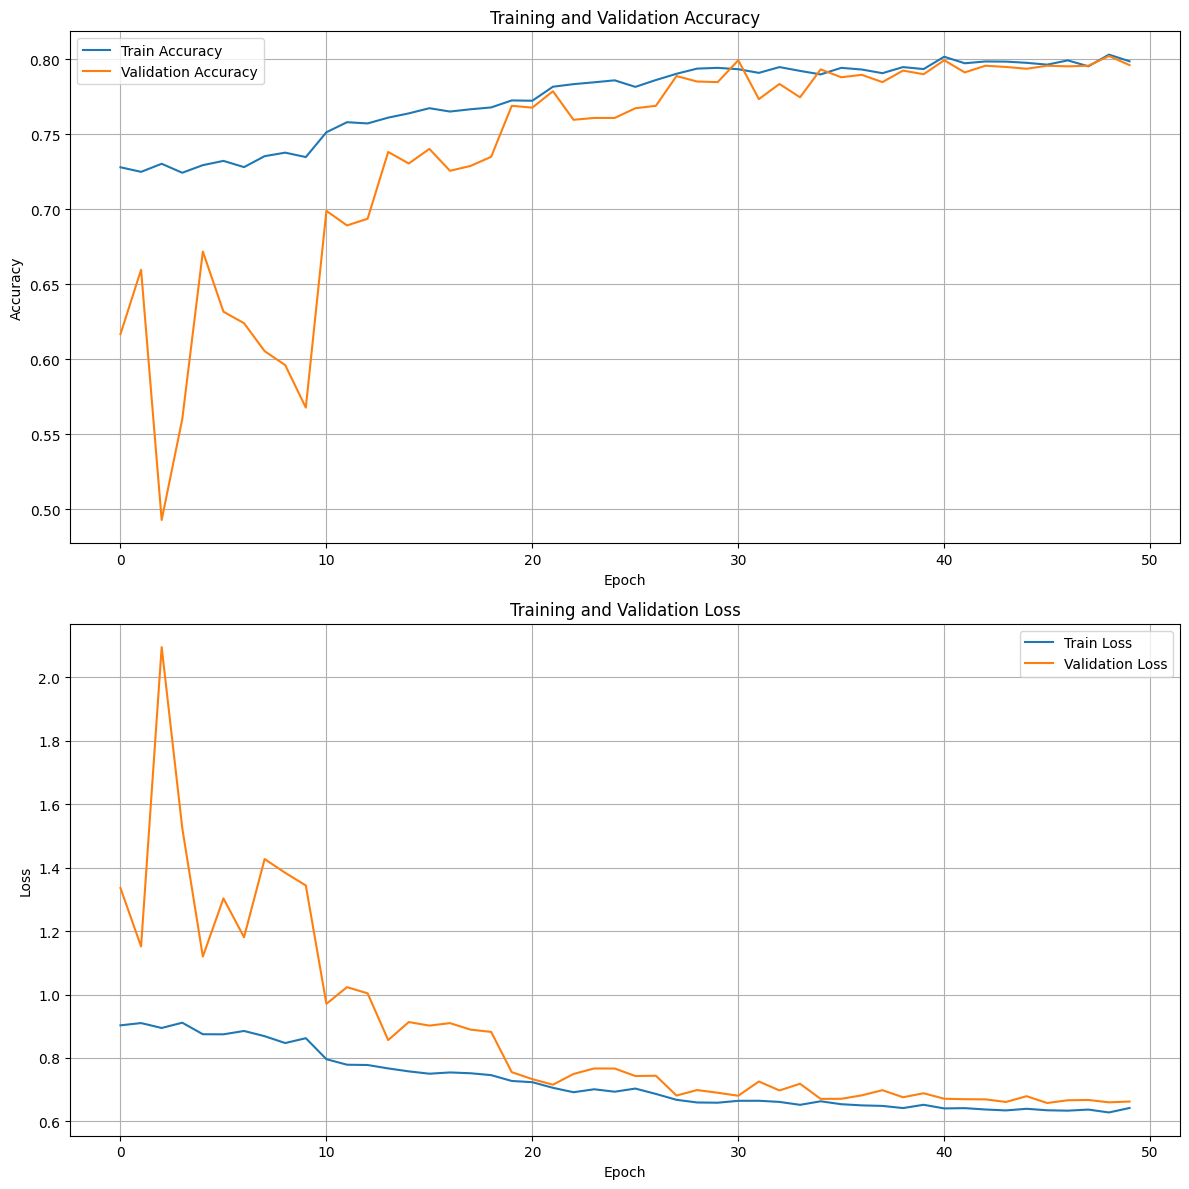

In [ ]:
# Plot the training history
import matplotlib.pyplot as plt

def plot_history(history):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

    # Accuracy
    ax1.plot(history.history['sparse_categorical_accuracy'], label='Train Accuracy')
    ax1.plot(history.history['val_sparse_categorical_accuracy'], label='Validation Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.set_title('Training and Validation Accuracy')
    ax1.legend()
    ax1.grid(True)

    # Loss
    ax2.plot(history.history['loss'], label='Train Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.set_title('Training and Validation Loss')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.savefig('/content/drive/My Drive/training_history.png')
    plt.show()

plot_history(history)

In [ ]:
import tensorflow as tf

def create_datasets(train_points, test_points, train_labels, test_labels, batch_size=32):
    """
    Creates TensorFlow datasets for training and evaluation.

    Args:
        train_points: Training point clouds
        test_points: Testing point clouds
        train_labels: Training labels
        test_labels: Testing labels
        batch_size: Batch size for training

    Returns:
        train_dataset, validation_dataset, test_dataset
    """
    def augment(points, label):
        # Jitter points (small random noise)
        points += tf.random.normal(points.shape, mean=0.0, stddev=0.01)

        # Random rotation about z-axis
        theta = tf.random.uniform((), 0, 2 * np.pi)
        cos_theta = tf.cos(theta)
        sin_theta = tf.sin(theta)

        rotation_matrix = tf.stack([
            [cos_theta, -sin_theta, 0],
            [sin_theta, cos_theta, 0],
            [0, 0, 1]
        ])

        points = tf.matmul(points, rotation_matrix)

        # Random scaling (between 80% and 120%)
        scale = tf.random.uniform((), 0.8, 1.2)
        points *= scale

        return points, label

    # Create datasets
    train_dataset = tf.data.Dataset.from_tensor_slices((train_points.astype(np.float32), train_labels))
    test_dataset = tf.data.Dataset.from_tensor_slices((test_points.astype(np.float32), test_labels))

    # Shuffle and apply augmentation to training data only
    train_dataset = train_dataset.shuffle(len(train_points)).map(augment).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    test_dataset = test_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return train_dataset, test_dataset

# Assuming `train_points`, `test_points`, `train_labels`, and `test_labels` are already loaded:
BATCH_SIZE = 32
_, test_dataset = create_datasets(train_points, test_points, train_labels, test_labels, BATCH_SIZE)


In [ ]:
from tensorflow.keras.models import load_model

final_model_path = "/content/drive/MyDrive/data_sets/Saved_Model_improv/final_model.keras"
model = load_model(final_model_path)

test_loss, test_accuracy = model.evaluate(validation_dataset)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.6229 - sparse_categorical_accuracy: 0.8078
Test Loss: 0.6579
Test Accuracy: 0.7958


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 853ms/step


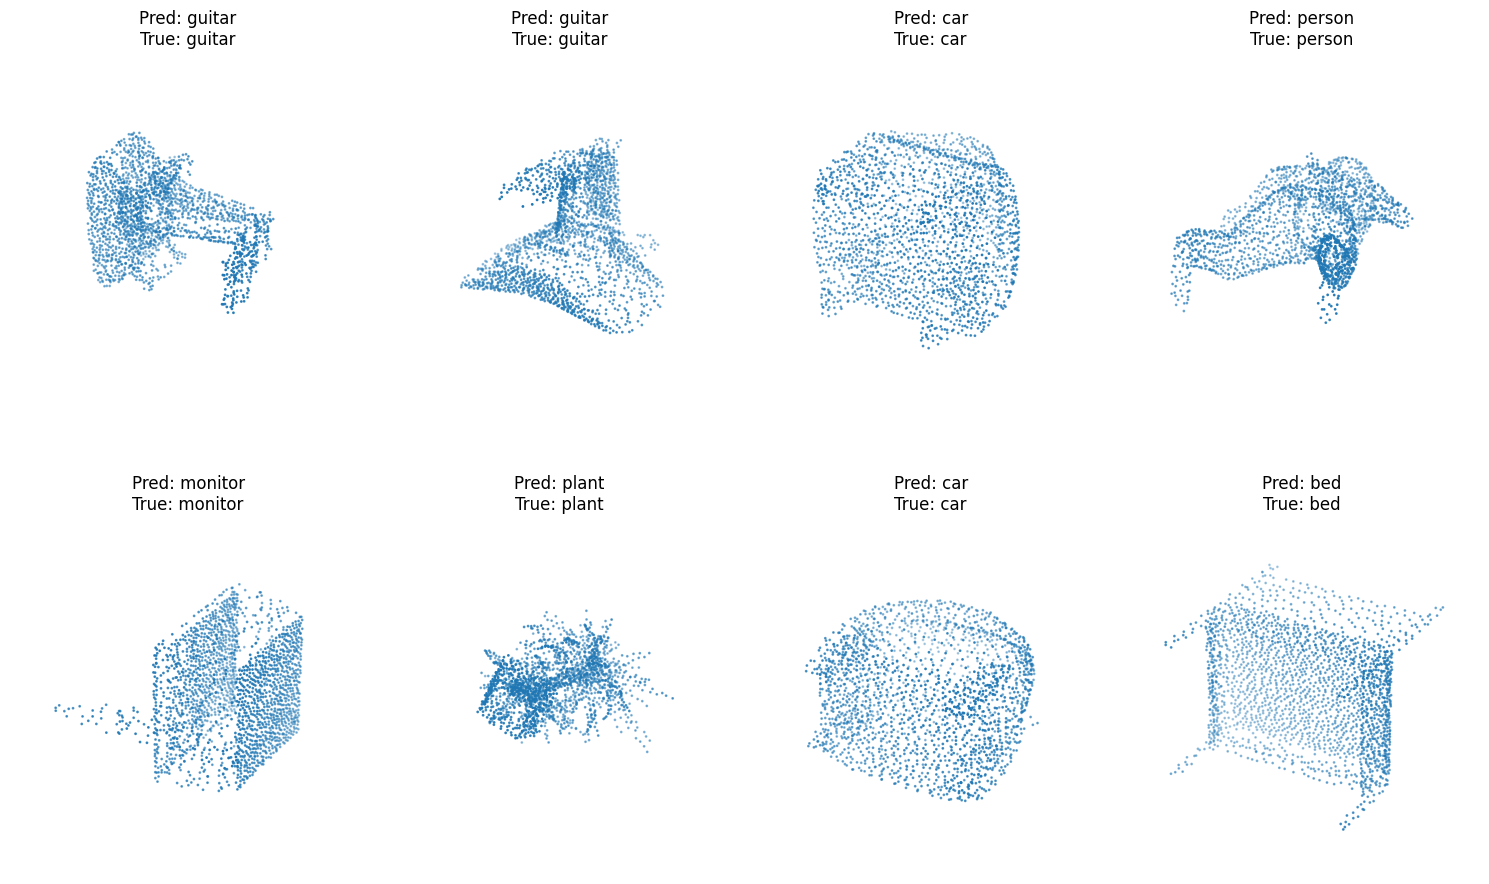

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def visualize_predictions(model, test_dataset, class_map):
    for points, labels in test_dataset.take(1):
        points_to_plot = points[:8].numpy()
        labels_to_plot = labels[:8].numpy()

        # Make predictions
        preds = model.predict(points_to_plot)
        pred_labels = tf.argmax(preds, axis=1).numpy()

        # Plot points with predicted class and label
        fig = plt.figure(figsize=(15, 10))
        for i in range(8):
            ax = fig.add_subplot(2, 4, i + 1, projection="3d")
            ax.scatter(points_to_plot[i, :, 0], points_to_plot[i, :, 1], points_to_plot[i, :, 2], s=1)
            ax.set_title(
                f"Pred: {class_map[pred_labels[i]]}\nTrue: {class_map[labels_to_plot[i]]}"
            )
            ax.set_axis_off()

        plt.tight_layout()
        plt.savefig('/content/drive/MyDrive/predictions.png')
        plt.show()
        break

# Visualize predictions
visualize_predictions(model, test_dataset, CLASS_MAP)
